In [182]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from datetime import datetime
current_datetime = datetime.now()
current_date_string = current_datetime.strftime("%Y-%m-%d")

filenames = {'IRMS':'CDD-IRMS.xlsx',
          'Orbitrap vanquish':'240208_CdD_202-215_M0/calibrated_deltas_2024-02-14.csv',
          'Orbitrap vanquish no-M0':'240212_CdD_202-215_noM0/calibrated_deltas_2024-02-14.csv',
          'Orbitrap syringe run 1':'240222_CdD_202-210_syringe_1/calibrated_deltas_2024-02-23.csv'}

## Import and organise deltas

In [183]:
data = filenames.copy()
labels = list(filenames.keys())

# Trim IRMS data to relevant lines, convert to not-permil
data['IRMS'] = pd.read_excel(filenames['IRMS'])[17:-1]
data['IRMS'][data['IRMS'].columns[1:]] = data['IRMS'][data['IRMS'].columns[1:]].copy()*1e-3
# Shift sample n to n+1
data['IRMS'].index = [int(name.split('-')[-1])+1 for name in data['IRMS']['sample_name']]

# Sort Orbitrap data similarly
for label in labels:
    if label != 'IRMS':
        data[label] = pd.read_csv(filenames[label]).drop('Unnamed: 0',axis=1)
        data[label].index = [int(name.split('-')[-1]) for name in data[label]['sample_name']]

# Calculate D17O values and errors       
for j,label in enumerate(data.keys()):
    data[label]['mean_D17O'] = data[label]['mean_d17O']-0.52*data[label]['mean_d18O']
    if label == 'IRMS':
        data[label]['err_D17O']=0.3e-3
    else:
        data[label]['err_D17O'] = np.sqrt( data[label]['err_d17O']**2 + 0.52*data[label]['err_d18O']**2 )

        
# Display
for label,df in data.items():
    print('Imported '+label+ ' data')
    print(pd.concat([df.head(2), df.tail(2)]))


Imported IRMS data
         sample_name  mean_d15N  mean_d17O  mean_d18O  err_d15N  err_d17O  \
203  CDD16-C01-C-202  -0.002624   0.057642   0.069255  0.000517  0.001147   
204  CDD16-C01-C-203  -0.002902   0.064592   0.084289  0.000517  0.001147   
214  CDD16-C01-C-213  -0.002792   0.060318   0.071186  0.000517  0.001147   
215  CDD16-C01-C-214  -0.004453   0.061502   0.072465  0.000517  0.001147   

     err_d18O  mean_D17O  err_D17O  
203  0.001744   0.021629    0.0003  
204  0.001744   0.020762    0.0003  
214  0.001744   0.023301    0.0003  
215  0.001744   0.023820    0.0003  
Imported Orbitrap vanquish data
    sample_name  mean_d15N  mean_d17O  mean_d18O  err_d15N  err_d17O  \
202     CDD-202  -0.002238   0.061657   0.070696  0.000604  0.001254   
203     CDD-203  -0.002570   0.053634   0.061417  0.000700  0.001141   
214     CDD-214  -0.004063   0.058550   0.066539  0.000652  0.001163   
215     CDD-215  -0.005812   0.057722   0.064847  0.000592  0.001251   

     err_d18O  me

## Plots

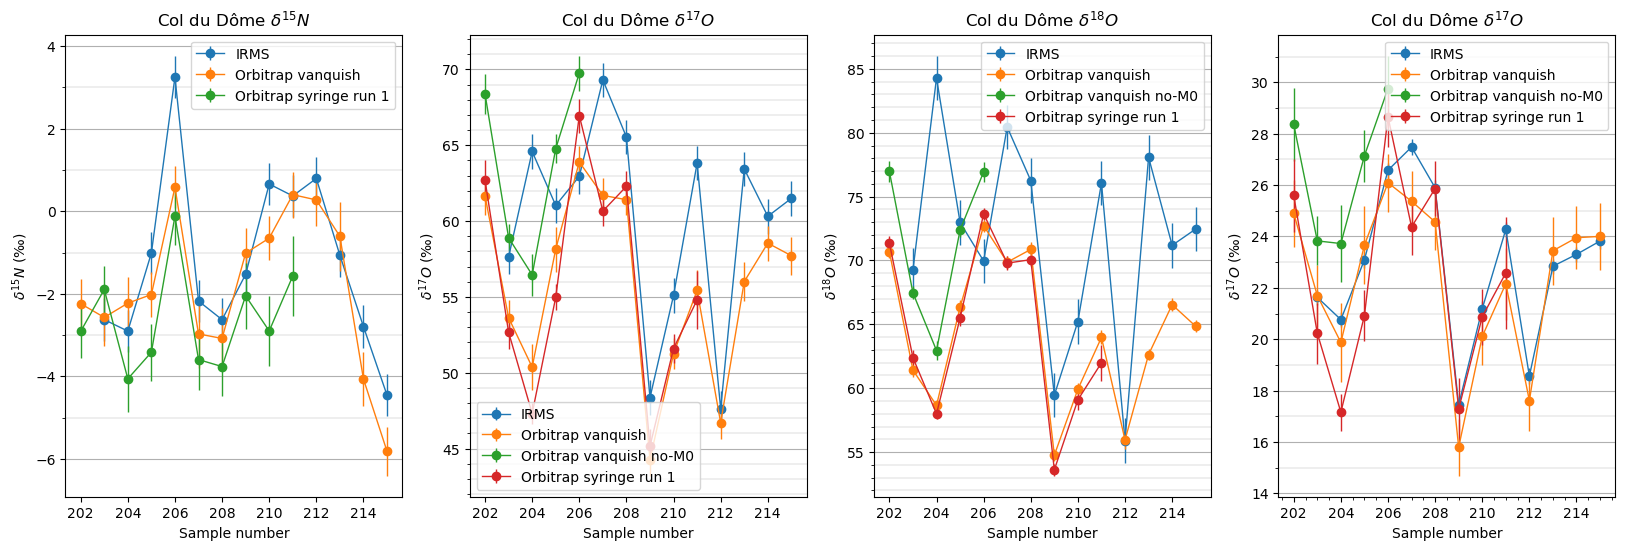

In [201]:
isotopologues = [ col[-4:] for col in data['IRMS'].columns if col.startswith('mean_')]

fig,ax = plt.subplots(1,4, figsize=[20,6])

# Plot isotopologues
for i,isotope in enumerate(isotopologues):
    for j,label in enumerate(data.keys()):
        if 'mean_'+isotope in data[label].columns:
            # plot data with errorbars
            ax[i].errorbar(data[label].index, data[label]['mean_'+isotope]*1e3, yerr = data[label]['err_'+isotope]*1e3, label=label,lw=1,marker='o')
    # plot parameters
    ax[i].set_ylabel('$\delta^{'+isotope[1:3]+'}'+isotope[3]+'$ (‰)')
    ax[i].set_xlabel('Sample number')
    ax[i].set_title('Col du Dôme $\delta^{'+isotope[1:3]+'}'+isotope[3]+'$')
    plt.minorticks_on()
    ax[i].yaxis.set_minor_locator(MultipleLocator(1))
    ax[i].grid(axis='y')
    ax[i].grid(axis='y', which='minor',lw=0.3)
    ax[i].legend()


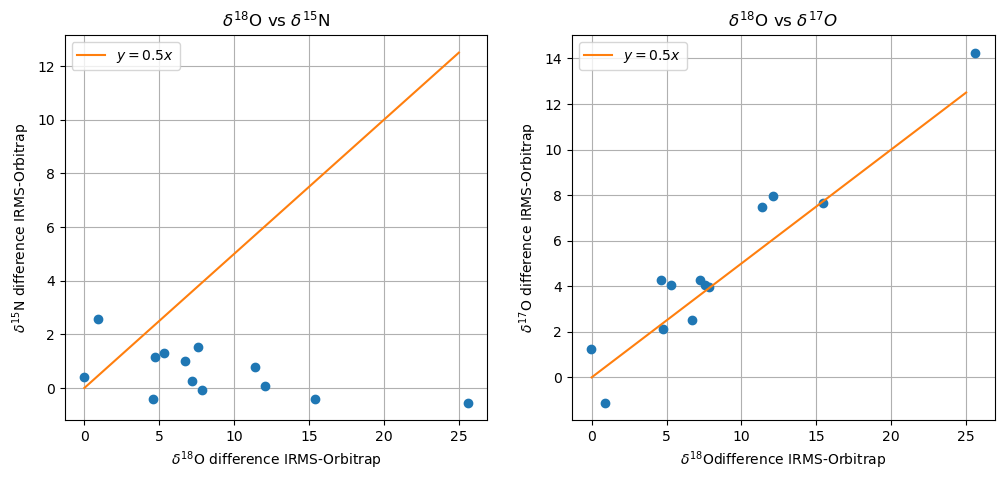

In [151]:
cols = ['d'+isotope+'_diff' for isotope in isotopes ]
diff = pd.DataFrame(columns=['sample.name']+cols)
diff['sample.name']=Orbitrap['sample.name']
for i,isotope in enumerate(isotopes):
    diff[cols[i]] = IRMS['d'+isotope+'_IRMS']-Orbitrap['mean_d'+isotope]

y1 = diff['d15N_diff']
y2 = diff['d17O_diff']
x = diff['d18O_diff']

fig,axes=plt.subplots(1,2,figsize=[12,5])

ax=axes[0]
ax.plot(x,y1,lw=0,marker='o')
ax.plot([0,25],[0,12.5],label='$y=0.5x$')
ax.set_xlabel('$\delta^{18}$O difference IRMS-Orbitrap')
ax.set_ylabel('$\delta^{15}$N difference IRMS-Orbitrap')
ax.set_title('$\delta^{18}$O vs $\delta^{15}$N')
ax.legend()
ax.grid()

ax=axes[1]
ax.plot(x,y2,lw=0,marker='o')
ax.plot([0,25],[0,12.5],label='$y=0.5x$')
ax.set_xlabel('$\delta^{18}$Odifference IRMS-Orbitrap')
ax.set_ylabel('$\delta^{17}$O difference IRMS-Orbitrap')
ax.set_title('$\delta^{18}$O vs $\delta^{17}O$')
ax.grid()
ax.legend()

# fig.savefig(folder+'/correlations.png')

/var/folders/rr/bz6rnlcn09b6b2ttxx8h8x5m0000gn/T/ipykernel_9495/2914125025.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(plt.gca().get_xticklabels(),rotation=90);


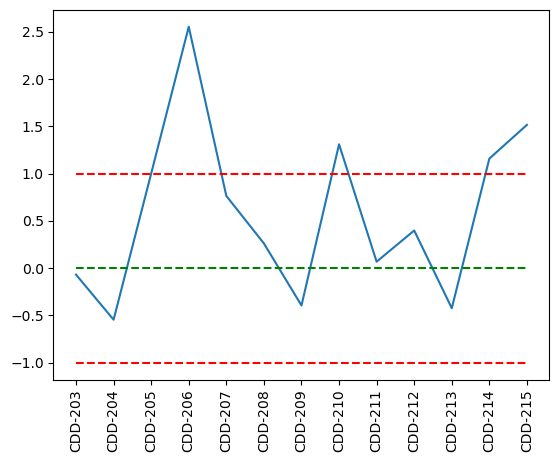

In [180]:
plt.plot(diff['sample.name'],diff['d15N_diff'])
plt.plot([0,12],[0,0],c='g',ls='--')
plt.plot([0,12],[1,1],c='r',ls='--')
plt.plot([0,12],[-1,-1],c='r',ls='--')
plt.gca().set_xticklabels(plt.gca().get_xticklabels(),rotation=90);

In [169]:
np.std(diff['d15N_diff'])/len(diff['d15N_diff'])**0.5

0.2419156662716485

(-3.0, 3.0)

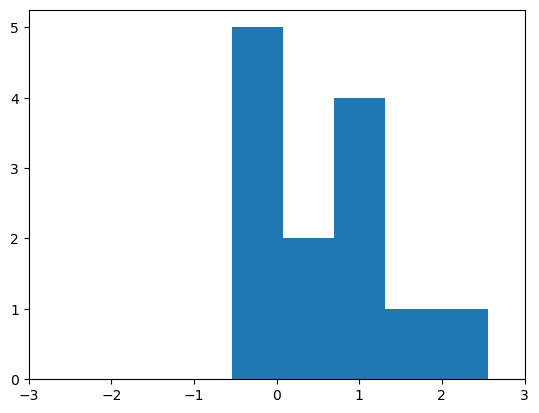

In [184]:
plt.hist(diff['d15N_diff'],bins=5)
plt.xlim([-3,3])

In [192]:
ans=(0.01*1e6*10*1000) * 0.4e-2*0.6e-2 * 100 
ans**-0.5

0.002041241452319315